# Riddle #1: An NEO with a peculiar orbit

**Author: Juan Luis Cano Rodríguez <hello@juanlu.space>**

## Statement

http://neo.ssa.esa.int/neocc-riddles

> The recently discovered asteroid 2020 HY5, firstly observed by Mt. Lem­
mon Survey on 23 April 2020, has an interesting particularity: it roughly
passes half of its orbital period of about 387 days inside 1.3 au and the
other half outside. Such distance is used for the definition of NEOs: the
perihelion distance of an NEO must be below 1.3 au. 2020 HY5 actually
spends 192.0 days below 1.3 au and 194.9 days above that distance.
>
> And here is a riddle:
> 
> - Assuming an NEO that spends exactly 50% of its time inside 1.3 au and
50% of its time outside 1.3 au, what would be the maximum aphelion
such an NEO could have?
> - As a bonus, would you be able to find similar cases in our database?
(Hint: you can use the advanced search functionality in our left menu)

## Solution

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sympy import init_printing, symbols, solve, nsolve, diff, Eq, sin, cos, Function, pi
from sympy.abc import a, b, e, E, r, p, nu

init_printing()

Remembering the second Kepler law of planetary motion:

> The area of the sector traced by the radius vector from the sun, between any two positions of a planet in its orbit, is proportional to the time occupied in passing from one position to the other.
> (Battin, 1999)

Therefore, if the time inside the NEO distance $R_0$ is the same as the time outside, the subtended areas must be the same.

Area of the focal sector of the ellipse:

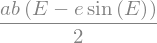

In [2]:
A = (E - e * sin(E)) * a * b / 2
A

where $E$ is the eccentric anomaly, $a$ and $b$ are the semimajor and semiminor axis respectively, and $e$ is the eccentricity.

We now equate the area for $E = E_0$ to the remaining area, that is $A - A(E_0)$, where $E_0$ is the eccentric anomaly at which $r = R_0$:

In [3]:
E0 = Function("E_0")(e)
E0

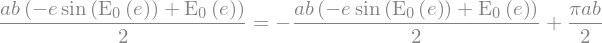

In [4]:
areas_eq = Eq(A.subs(E, E0), A.subs(E, pi) - A.subs(E, E0))
areas_eq

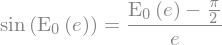

In [5]:
E0_eq = Eq(sin(E0), solve(areas_eq, sin(E0))[0])
E0_eq

This is the same as

$$E_0 - e \sin(E_0) = \frac{\pi}{2}$$

Now we use the polar equation of the ellipse:

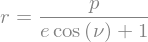

In [6]:
polar_eq = Eq(r, p / (1 + e * cos(nu)))
polar_eq

Where $p$ is the semilatus rectum and $nu$ is the true anomaly.

Using the relation between true anomaly $\nu$ and eccentric anomaly $E$:

$$\cos{\nu} = \frac{\cos{E} - e}{1 - e \cos{E}}$$

We can obtain an expression for $p$ in terms of $E$:

In [7]:
R0 = symbols("R_0")
R0

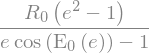

In [8]:
p_eq = solve(
    polar_eq.subs(cos(nu), (cos(E) - e) / (1 - e * cos(E))).subs(E, E0).subs(r, R0),
    p
)[0]
p_eq

And now we use the relation between the apocenter $r_a$ and the semilatus rectum $p$ to solve for our variable of interest:

In [9]:
r_a = symbols("r_a")
r_a

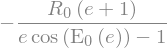

In [10]:
r_a_eq = solve(Eq(r_a * (1 - e), p_eq), r_a)[0]
r_a_eq

The problem statement suggests that the aphelion has a maximum. Is that true? Let's visualize it numerically first.

If we fix the eccentricity $e$, we get a value of the aphelion:

- $e = 0.1$
- $R_0 = 1.3$

In [11]:
E0_ = nsolve((E - e * sin(E) - pi / 2).subs(e, 0.1), E, 1.5)
E0_

In [12]:
r_a_ = r_a_eq.subs(E0, E0_).subs(e, 0.1).subs(R0, 1.3)
r_a_

Let's plot the aphelion $r_a$ versus the eccentricity $e$:

In [13]:
def compute_r_a(e_, R0_=1.3):
    E0_ = nsolve((E - e * sin(E) - pi / 2).subs(e, e_), (pi / 2).evalf())
    return r_a_eq.subs(E0, E0_).subs(e, e_).subs(R0, R0_)

In [14]:
e_arr = np.linspace(0, 1, 101)
r_a_arr = np.zeros_like(e_arr)

for ii, e_ in enumerate(e_arr):
    r_a_arr[ii] = float(compute_r_a(e_))

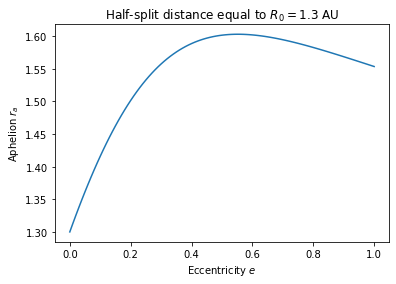

In [15]:
fig, ax = plt.subplots()

l, = ax.plot(e_arr, r_a_arr)

ax.set_xlabel("Eccentricity $e$")
ax.set_ylabel("Aphelion $r_a$")

t = ax.set_title("Half-split distance equal to $R_0 = 1.3$ AU")

There is a maximum! Let's find it by equating the derivative of $r_a$ with respect to $e$ to zero:

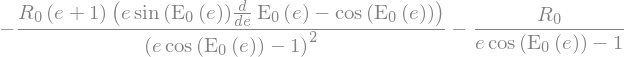

In [16]:
diff(r_a_eq, e)

We solve for $\frac{d}{de} E_0(e)$ by differentiating the implicit equation:

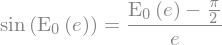

In [17]:
E0_eq

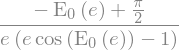

In [18]:
dE0_e = solve(
    Eq(
        diff(E0_eq.lhs, e),
        diff(E0_eq.rhs, e),
    ),
    diff(E0, e)
)[0]
dE0_e

And now replace:

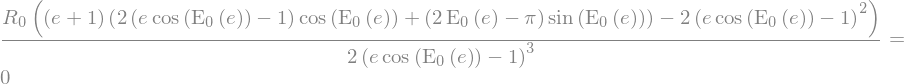

In [19]:
max_r_a_eq = Eq(diff(r_a_eq, e).subs(diff(E0, e), dE0_e), 0).simplify()
max_r_a_eq

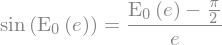

In [20]:
E0_eq

We have a system of two nonlinear equations for the eccentricy $e$ and the half-split eccentric anomaly $E_0$. One of them can be trivially solved for $e$, and we can replace that solution in the other one to end with a single equation in $E_0$:

In [21]:
E0_ = symbols("E0_")
E0_

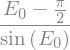

In [22]:
e_ = solve(E0_eq.subs(E0, E0_), e)[0]
e_

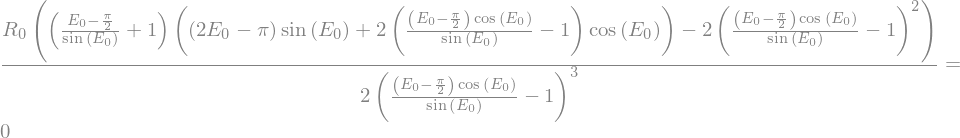

In [23]:
max_r_a_eq_E0 = max_r_a_eq.subs(E0, E0_).subs(e, e_)
max_r_a_eq_E0

And finally, we solve numerically:

In [24]:
E0_max_r_a = nsolve(max_r_a_eq_E0.subs(R0, 1.3).lhs, 2)
E0_max_r_a

In [25]:
e_max_r_a = e_.subs(E0_, E0_max_r_a).evalf()
e_max_r_a

Therefore, **the maximum aphelion this peculiar NEO can have is**:

In [26]:
max_r_a = r_a_eq.subs(R0, 1.3).subs(E0, E0_max_r_a).subs(e, e_max_r_a)
max_r_a

■

This theoretical value is in fact very close to the actual aphelion of [2020 HY5](http://neo.ssa.esa.int/search-for-asteroids?sum=1&des=2020HY5): 1.609 AU.

To find other similar cases, we can pick pairs of (eccentricity, aphelion) that fulfill the condition we analyzed above:

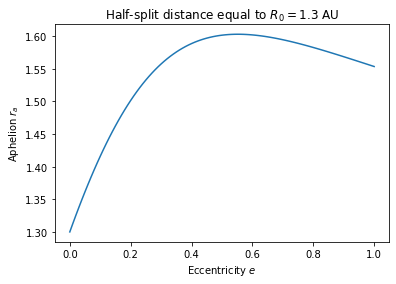

In [27]:
fig

Alternatively, we can compute the "time fraction" $\tau$: time spent inside $R_0$ over time spent outside:

$$\tau = \frac{T_i}{T_e} = \frac{2 n (E_0 - e \sin{E_0})}{2 n \pi - 2 n (E_0 - e \sin{E_0})} =
\frac{E_0 - e \sin{E_0}}{\pi - (E_0 - e \sin{E_0})}
$$

For that, we explore a grid of $(e, r_a)$ pairs, which give us the shape of the orbit, and compute $E_0$ as the intersection with $R_0$:

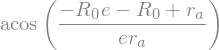

In [28]:
E0_direct = solve(
    polar_eq.subs(r, R0).subs(p, r_a * (1 - e)).subs(cos(nu), (cos(E0_) - e) / (1 - e * cos(E0_))),
    E0_
)[-1]
E0_direct

which we can then use to calculate $\tau$:

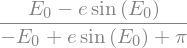

In [29]:
tau = (E0_ - e * sin(E0_)) / (pi - (E0_ - e * sin(E0_)))
tau

In [30]:
e_arr_xx, r_a_arr_yy = np.meshgrid(
    np.linspace(0, 1, num=101),
    np.linspace(1.3, 1.65, num=101)
)

tau_xx_yy = np.zeros_like(e_arr_xx)

for ii in range(e_arr_xx.shape[0]):
    for jj in range(e_arr_xx.shape[1]):
        e_ii_jj = e_arr_xx[ii, jj]
        r_a_ii_jj = r_a_arr_yy[ii, jj]

        try:
            E0_ii_jj = float(E0_direct.subs(R0, 1.3).subs(e, e_ii_jj).subs(r_a, r_a_ii_jj))
        except TypeError:
            # Some solutions are complex
            E_ii_jj = float("nan")

        tau_xx_yy[ii, jj] = float(tau.subs(e, e_ii_jj).subs(E0_, E0_ii_jj))

And now we visualize it:

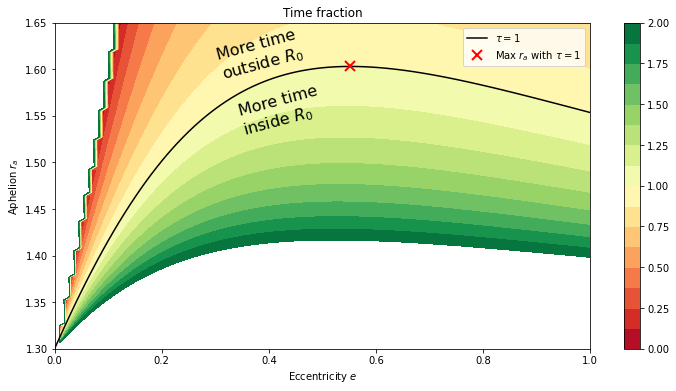

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))

c = ax.contourf(
    e_arr_xx, r_a_arr_yy, tau_xx_yy,
    levels=np.linspace(0, 2, 17), cmap=plt.cm.RdYlGn,
)
ax.plot(e_arr, r_a_arr, color="black", label=r"$\tau = 1$")

ax.plot(
    e_max_r_a, max_r_a, "x", markeredgewidth=2, color="red", markersize=10,
    label=r"Max $r_a$ with $\tau = 1$"
)

ax.text(0.34, 1.53, "More time\ninside $R_0$", {"fontsize": 16}, rotation=15)
ax.text(0.30, 1.59, "More time\noutside $R_0$", {"fontsize": 16}, rotation=15)

ax.legend()

ax.set_xlabel("Eccentricity $e$")
ax.set_ylabel("Aphelion $r_a$")

t = ax.set_title("Time fraction")

cb = fig.colorbar(c)

For example, the region with $e \in [0.4, 0.8]$ and $r_a \in [1.5, 1.6]$ will have a time fraction close to 1. Using these filters in the [ESA NEO Coordination Centre Advanced Search](http://neo.ssa.esa.int/advanced-search), we find about 150 examples, like [1865 Cerberus](http://neo.ssa.esa.int/search-for-asteroids?sum=1&des=1865%20Cerberus):

- Perihelion: 0.576 AU
- Aphelion: 1.584 AU
- Eccentricity: 0.467
- Period: 409.9 days

The eccentric anomaly of the intersection at $R_0$ is:

In [32]:
E0_1865_Cerberus = E0_direct.subs(R0, 1.3).subs(e, 0.467).subs(r_a, 1.584)
E0_1865_Cerberus

And its time fraction is:

In [33]:
tau_1865_Cerberus = tau.subs(e, 0.467).subs(E0_, E0_1865_Cerberus).evalf()
tau_1865_Cerberus

In [34]:
tau_1865_Cerberus / (1 + tau_1865_Cerberus) * 409.9

Therefore, it spends about 209 days inside $R_0 = 1.3$ AU, and 200 days outside that radius.

On the other hand, [2005EP1](http://neo.ssa.esa.int/search-for-asteroids?sum=1&des=2005EP1) has this orbit:

- Perihelion: 0.205 AU
- Aphelion: 1.58 AU
- Eccentricity: 0.77
- Period: 307.9 days

In [35]:
E0_2005EP1 = E0_direct.subs(R0, 1.3).subs(e, 0.77).subs(r_a, 1.58)
E0_2005EP1

In [36]:
tau_2005EP1 = tau.subs(e, 0.77).subs(E0_, E0_2005EP1).evalf()
tau_2005EP1

In [37]:
tau_2005EP1 / (1 + tau_2005EP1) * 307.9

This one spends 155 days inside, and 153 days outside.

## References

1. Battin, R. (1999). _An introduction to the mathematics and methods of astrodynamics, revised edition_. American Institute of Aeronautics and Astronautics.